In diesem Notebook werden auf verschiedenen Modalitäten verschiedene Modelle trainiert, angewendet und ausgewertet. Jeweils: Random Forest, XGBoost, Logistic Regression, SVM, Neuronales Netz

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score

c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# Vorbereitung: Data Split in 3 Datasets!

Preprocessing der Kategorsischen Variablen..

In [ ]:
df = pd.read_csv("features_enriched_tab_img_text.csv")
print(df.shape)
print(df.columns)

df = df.rename(
    columns={
        "stars": "tab_star",
        "year": "tab_year",
        "month": "tab_month",
        "day": "tab_day",
        "likesCount": "tab_likesCount",
        "reviewerNumberOfReviews": "tab_reviewerNumberOfReviews",
        "isLocalGuide": "tab_isLocalGuide",
        "dayofweek": "tab_dayofweek",
        "elapsed_days": "tab_elapsed_days",
        "when_on_day_4hbin": "tab_when_on_day_4hbin",
    }
)

df["label"] = df["label"].replace({"real": 0, "fake": 1})
df["text_sentiment"] = df["text_sentiment"].replace(
    {"negative": 0, "neutral": 1, "positive": 2}
)

df_num = df.select_dtypes(include=["float64", "int64"])
df_cat = df.select_dtypes(include=["object"])

df.to_csv("features_enriched_tab_img_text_preproc.csv", index=False)

Train-Validation-Test-Split.

In [ ]:
df = pd.read_csv('features_enriched_tab_img2_text_preproc.csv')
print(f"Orginal:\t{df.shape}")
print("---------------------------------------------------------------------------------------------")

train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train_val, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=1)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val['label'], random_state=1)
print(f"Train:\t\t{train.shape}")
print(f"Validation:\t{val.shape}")
print(f"Test:\t\t{test.shape}")

train.to_csv('detection_train.csv', index=False)
val.to_csv('detection_val.csv', index=False)
test.to_csv('detection_test.csv', index=False)
train_val.to_csv('detection_train_val.csv', index=False)

## Baseline mit Dummy-Klassifikator: Coinflip

In [ ]:
from sklearn.dummy import DummyClassifier

train_df = pd.read_csv("detection_train.csv")
val_df = pd.read_csv("detection_val.csv")
test_df = pd.read_csv("detection_test.csv")


def apply_and_eval_dummy_on_val (used_features):
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    dummy = DummyClassifier(strategy="uniform", random_state=1)
    dummy.fit(X_train, y_train)
    y_pred_val = dummy.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    confusion = confusion_matrix(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_pred_val)
    
    accuracy = "{:.4f}".format(accuracy)
    f1 = "{:.4f}".format(f1)
    precision = "{:.4f}".format(precision)
    recall = "{:.4f}".format(recall)
    auc = "{:.4f}".format(auc)
    print(f"VALIDATION: \naccuarcy:\t{accuracy}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")
    #return accuracy, f1, precision, recall, confusion, auc

def apply_and_eval_dummy_classificator_on_test(used_features):
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    X_test, y_test = test_df[used_features], test_df["label"]

    dummy = DummyClassifier(strategy="uniform", random_state=1)
    dummy.fit(X_train, y_train)
    y_pred_val = dummy.predict(X_val)
    y_pred_test = dummy.predict(X_test)
    accuracy_val = accuracy_score(y_val, y_pred_val)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_test)

    accuracy_val = "{:.4f}".format(accuracy_val)
    accuracy_test = "{:.4f}".format(accuracy_test)
    f1 = "{:.4f}".format(f1)
    precision = "{:.4f}".format(precision)
    recall = "{:.4f}".format(recall)
    auc = "{:.4f}".format(auc)
    print(f"acc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")
    #return  accuracy_test, f1, precision, recall, confusion, auc


used_features_img0 = train_df.filter(regex="^(feature)").columns
used_features_img2 = train_df.filter(regex="^(img_feature)").columns
used_features_tab = train_df.filter(regex="^(tab_)").columns
used_features_text = train_df.filter(regex="^(text_)").columns
used_features_all = train_df.filter(regex="^(feature|img_feature|tab_|text_)").columns


print(f"____________________________Test: EVALUATION_DUMMY_CLASSIFICATOR: Image Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_img0)
print(f"____________________________Test:EVALUATION_DUMMY_CLASSIFICATOR: Image (Url/2) Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_img2)
print(f"____________________________Test: EVALUATION_DUMMY_CLASSIFICATOR: tab Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_tab)
print(f"____________________________Test: EVALUATION_DUMMY_CLASSIFICATOR: text Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_text)
print(f"____________________________Test: EVALUATION_DUMMY_CLASSIFICATOR: all Features_________________________________________________")
apply_and_eval_dummy_classificator_on_test(used_features_all)

# XGBoost

____________________________XGB ON TEST - ImageUrls/0 Features_________________________________________________
acc_test:	0.8865
Precision:	0.8811
Recall:		0.8936
F1-Score:	0.8873
AUC:		0.8865
Confusion matrix:
[[124  17]
 [ 15 126]]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


____________________________XGB ON TEST: tab Features_________________________________________________
acc_test:	0.7199
Precision:	0.7385
Recall:		0.6809
F1-Score:	0.7085
AUC:		0.7199
Confusion matrix:
[[107  34]
 [ 45  96]]


 99%|===================| 895/900 [00:32<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


____________________________XGB ON TEST: text Features_________________________________________________
acc_test:	0.5567
Precision:	0.5548
Recall:		0.5745
F1-Score:	0.5645
AUC:		0.5567
Confusion matrix:
[[76 65]
 [60 81]]


 95%|=================== | 855/900 [00:17<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


____________________________XGB ON TEST: tab + text Features_________________________________________________
acc_test:	0.7163
Precision:	0.7163
Recall:		0.7163
F1-Score:	0.7163
AUC:		0.7163
Confusion matrix:
[[101  40]
 [ 40 101]]


 97%|=================== | 871/900 [00:13<00:00]       No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


____________________________XGB ON TEST: text + ImageUrls/0 Features_________________________________________________
acc_test:	0.8972
Precision:	0.8944
Recall:		0.9007
F1-Score:	0.8975
AUC:		0.8972
Confusion matrix:
[[126  15]
 [ 14 127]]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


____________________________XGB ON TEST: tab + ImageUrls/0 Features_________________________________________________
acc_test:	0.9291
Precision:	0.9172
Recall:		0.9433
F1-Score:	0.9301
AUC:		0.9291
Confusion matrix:
[[129  12]
 [  8 133]]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


____________________________XGB ON TEST: tab + text + ImageUrls/0 Features_________________________________________________
acc_test:	0.9149
Precision:	0.9149
Recall:		0.9149
F1-Score:	0.9149
AUC:		0.9149
Confusion matrix:
[[129  12]
 [ 12 129]]


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


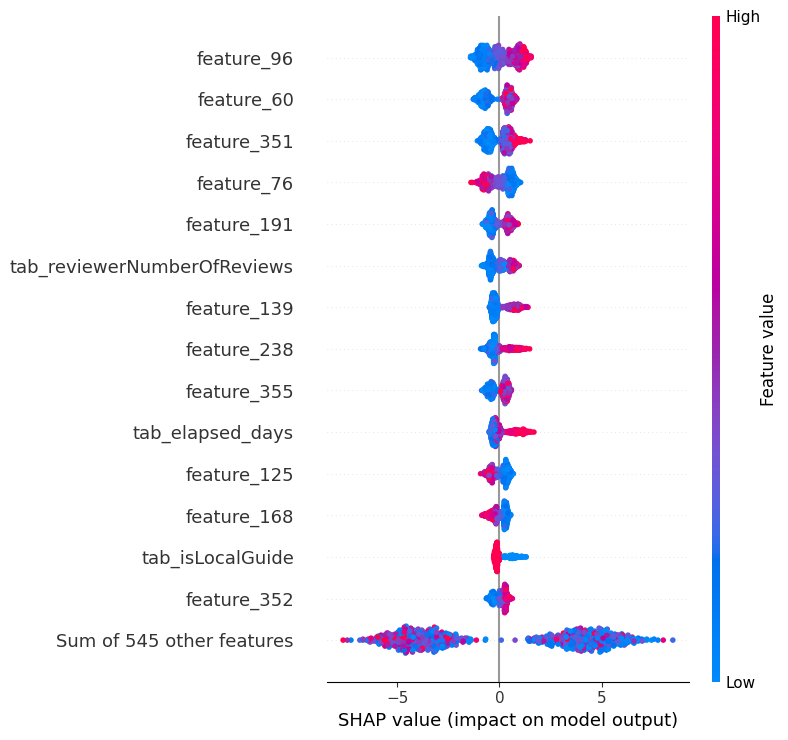

In [13]:
from xgboost import XGBClassifier
import shap
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv("detection_train.csv")
val_df = pd.read_csv("detection_val.csv")
test_df = pd.read_csv("detection_test.csv")

def apply_and_eval_xgb_on_val(used_features, svg_file_suffix):
    plt.clf()
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    
    # Standardisierung
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)

    xgb = XGBClassifier(random_state=3, n_estimators=1000)
    xgb.fit(X_train_std, y_train)
    y_pred_val = xgb.predict(X_val_std)

    accuracy = accuracy_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    confusion = confusion_matrix(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_pred_val)
    print(f"VALIDATION SET: \naccuracy:\t{accuracy}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nF1-Score:\t{f1}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")

    explainer = shap.Explainer(xgb, X_train_std, feature_names=X_train.columns)
    shap_values = explainer(X_train_std)
    shap.plots.beeswarm(shap_values, max_display=15,show=False) 
    plt.tight_layout()
    plt.savefig(f'shap_xbg_test_{svg_file_suffix}.svg', format='svg', dpi=1200)
    #return  accuracy_test, f1, precision, recall, confusion, auc

def apply_and_eval_xgb_on_test(used_features, svg_file_suffix):
    plt.clf()
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    X_test, y_test = test_df[used_features], test_df["label"]
    
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)

    xgb = XGBClassifier(random_state=3, n_estimators=1000)
    xgb.fit(X_train_std, y_train)
    y_pred_test = xgb.predict(X_test_std)

    accuracy_test = float("{:.4f}".format(accuracy_score(y_test, y_pred_test)))
    precision = float("{:.4f}".format(precision_score(y_test, y_pred_test)))
    recall = float("{:.4f}".format(recall_score(y_test, y_pred_test)))
    f1 = float("{:.4f}".format(f1_score(y_test, y_pred_test)))
    auc = float("{:.4f}".format(roc_auc_score(y_test, y_pred_test)))
    confusion = confusion_matrix(y_test, y_pred_test)
    print(f"acc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nF1-Score:\t{f1}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")
    # print some examples of false predictions

    explainer = shap.Explainer(xgb, X_train_std, feature_names=X_train.columns)
    shap_values = explainer(X_train_std)
    shap.plots.beeswarm(shap_values, max_display=15,show=False, ) 
    plt.tight_layout()
    plt.savefig(f'shap_xbg_test_{svg_file_suffix}.svg', format='svg', dpi=1200)
    #return accuracy_test, f1, precision, recall, confusion, auc


used_features_img0 = train_df.filter(regex="^(feature)").columns
used_features_img2 = train_df.filter(regex="^(img_feature)").columns
used_features_tab = train_df.filter(regex="^(tab_)").columns
used_features_text = train_df.filter(regex="^(text_)").columns
used_features_tab_text = train_df.filter(regex="^(tab_|text_)").columns
used_features_text_img0 = train_df.filter(regex="^(text_|feature)").columns
used_features_text_img2 = train_df.filter(regex="^(text_|img_feature)").columns
used_features_tab_img0 = train_df.filter(regex="^(tab_|feature)").columns
used_features_tab_img2 = train_df.filter(regex="^(tab_|img_feature)").columns
used_features_tab_text_img0 = train_df.filter(regex="^(tab_|text_|feature)").columns
used_features_tab_text_img2 = train_df.filter(regex="^(tab_|text_|img_feature)").columns

# Einzelen Datenmodalitäten: 
print(f"____________________________XGB ON TEST - ImageUrls/0 Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_img0, "img0")
# print(f"___________________________XGB ON TEST: ImageUrls/2 Features_________________________________________________")
# apply_and_eval_xgb_on_test(used_features_img2, "img2")
print(f"____________________________XGB ON TEST: tab Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_tab, "tab")
print(f"____________________________XGB ON TEST: text Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_text, "text")

# Kombinationen aus Datenmodalitäten:
print(f"____________________________XGB ON TEST: tab + text Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_tab_text, "tab_text")
print(f"____________________________XGB ON TEST: text + ImageUrls/0 Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_text_img0, "text_img0")
# print(f"____________________________XGB ON TEST: text + ImageUrls/2 Features_________________________________________________")
# apply_and_eval_xgb_on_test(used_features_text_img2, "text_img2")
print(f"____________________________XGB ON TEST: tab + ImageUrls/0 Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_tab_img0, "tab_img0")
# print(f"____________________________XGB ON TEST: tab + ImageUrls/2 Features_________________________________________________")
# apply_and_eval_xgb_on_test(used_features_tab_img2, "tab_img2")

# Drei Datenmodalitäten:
print(f"____________________________XGB ON TEST: tab + text + ImageUrls/0 Features_________________________________________________")
apply_and_eval_xgb_on_test(used_features_tab_text_img0, "tab_text_img0")
# print(f"____________________________XGB ON TEST: tab + text + ImageUrls/2 Features_________________________________________________")
# apply_and_eval_xgb_on_test(used_features_tab_text_img2, "tab_text_img2")

# TabNet - Neuronales Netz für Tabulare Daten

In [10]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv("detection_train.csv")
val_df = pd.read_csv("detection_val.csv")
test_df = pd.read_csv("detection_test.csv")

def train_and_tune_tabNet(used_features, svg_file_suffix):       
    plt.clf()
    X_train_org, y_train = train_df[used_features], train_df["label"]
    X_val_org, y_val = val_df[used_features], val_df["label"]

    print(f"Eventuell NAs entfernen:")
    print(f"Train Shape mit na: {X_train_org.shape}")
    print(f"Val Shape mit na: {X_val_org.shape}")
    X_train = X_train_org.dropna()
    X_val = X_val_org.dropna()
    print(f"Train Shape ohne na: {X_train.shape}")
    print(f"Val Shape ohne na: {X_val.shape}")

    # Standardization
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
 
    print(X_train_std.dtype)
    print(f"Used Features: {used_features}")

    tabNet = TabNetClassifier(verbose=1, seed=42)
    tabNet.fit(
        X_train=X_train_std,
        y_train=y_train,
        patience=2,
        max_epochs=50,
        eval_set=[(X_val_std, y_val)],
        eval_metric=["accuracy", "auc"],
        batch_size=32
    )

    X_test, y_test = test_df[used_features], test_df["label"]
    X_test = X_test.dropna()
    X_test_std = scaler.transform(X_test)
    y_test = y_test.to_numpy().squeeze()
    y_pred_test = tabNet.predict(X_test_std)
    y_pred_test_proba = tabNet.predict_proba(X_test_std)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    confusion = confusion_matrix(y_test, y_pred_test)
    auc = roc_auc_score(y_test, y_pred_test)
    print(
        f"acc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nF1-Score:\t{f1}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}"
    )

    # Aufgrund langer Laufzeiten abgebrochen

    # def tabnet_predict(input_data):
    #     input_data = torch.tensor(input_data).float()
    #     return tabNet.predict_proba(input_data)[:,1]
    # explainer = shap.Explainer(tabnet_predict, X_train)
    # shap_values = explainer(X_train, max_evals=1500)
    # shap.plots.beeswarm(shap_values, max_display=15, show=False) 
    # plt.tight_layout()
    # plt.savefig(f'shap_rf_test_{svg_file_suffix}.svg', format='svg', dpi=1200)

used_features_img0 = train_df.filter(regex="^(feature)").columns
used_features_img2 = train_df.filter(regex="^(img_feature)").columns
used_features_tab = train_df.filter(regex="^(tab_)").columns
used_features_text = train_df.filter(regex="^(text_)").columns
used_features_all = train_df.filter(regex="^(feature|tab_|text_)").columns

print(
    f"____________________________TabNet ON TEST - ImageUrls/2 Features_________________________________________________"
)
train_and_tune_tabNet(used_features_img0, "img0")

____________________________TabNet ON TEST - ImageUrls/2 Features_________________________________________________
Eventuell NAs entfernen:
Train Shape mit na: (900, 512)
Val Shape mit na: (226, 512)
Train Shape ohne na: (900, 512)
Val Shape ohne na: (226, 512)
float64
Used Features: Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'feature_502', 'feature_503', 'feature_504', 'feature_505',
       'feature_506', 'feature_507', 'feature_508', 'feature_509',
       'feature_510', 'feature_511'],
      dtype='object', length=512)


C:\Users\michi\AppData\Roaming\Python\Python39\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.72832 | val_0_accuracy: 0.49115 | val_0_auc: 0.43034 |  0:00:00s
epoch 1  | loss: 0.69341 | val_0_accuracy: 0.59292 | val_0_auc: 0.58423 |  0:00:01s
epoch 2  | loss: 0.68031 | val_0_accuracy: 0.5885  | val_0_auc: 0.63082 |  0:00:02s
epoch 3  | loss: 0.66449 | val_0_accuracy: 0.68584 | val_0_auc: 0.72919 |  0:00:02s
epoch 4  | loss: 0.59384 | val_0_accuracy: 0.69027 | val_0_auc: 0.75973 |  0:00:03s
epoch 5  | loss: 0.5744  | val_0_accuracy: 0.76549 | val_0_auc: 0.80343 |  0:00:04s
epoch 6  | loss: 0.52573 | val_0_accuracy: 0.78761 | val_0_auc: 0.84697 |  0:00:04s
epoch 7  | loss: 0.49825 | val_0_accuracy: 0.83186 | val_0_auc: 0.88613 |  0:00:05s
epoch 8  | loss: 0.43081 | val_0_accuracy: 0.84071 | val_0_auc: 0.88824 |  0:00:06s
epoch 9  | loss: 0.40337 | val_0_accuracy: 0.84071 | val_0_auc: 0.92584 |  0:00:07s
epoch 10 | loss: 0.32596 | val_0_accuracy: 0.86726 | val_0_auc: 0.94017 |  0:00:08s
epoch 11 | loss: 0.30151 | val_0_accuracy: 0.88938 | val_0_auc: 0.93492 |  0

C:\Users\michi\AppData\Roaming\Python\Python39\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


acc_test:	0.8900709219858156
Precision:	0.8928571428571429
Recall:		0.8865248226950354
F1-Score:	0.8896797153024911
AUC:		0.8900709219858155
Confusion matrix:
[[126  15]
 [ 16 125]]


<Figure size 640x480 with 0 Axes>

# Random Forests

In [ ]:
train_df = pd.read_csv("detection_train.csv")
val_df = pd.read_csv("detection_val.csv")
test_df = pd.read_csv("detection_test.csv")

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import shap
from sklearn.preprocessing import StandardScaler

train_df = pd.read_csv("detection_train.csv")
val_df = pd.read_csv("detection_val.csv")
test_df = pd.read_csv("detection_test.csv")

def apply_and_eval_rf_on_val(used_features, svg_file_suffix):
    plt.clf()
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]

    # Standardization
    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)

    rf = RandomForestClassifier(random_state=3, n_estimators=1000)
    rf.fit(X_train_std, y_train)
    y_pred_val = rf.predict(X_val_std)

    accuracy =  "{:.4f}".format(accuracy_score(y_val, y_pred_val))
    precision = "{:.4f}".format(precision_score(y_val, y_pred_val))
    recall = "{:.4f}".format(recall_score(y_val, y_pred_val))
    f1 = "{:.4f}".format(f1_score(y_val, y_pred_val))
    auc = "{:.4f}".format(roc_auc_score(y_val, y_pred_val))
    confusion = confusion_matrix(y_val, y_pred_val)
    
    print(f"VALIDATION SET: \naccuracy:\t{accuracy}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nF1-Score:\t{f1}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")

    explainer = shap.Explainer(rf, X_train_std, feature_names=X_train.columns)
    shap_values = explainer(X_train_std)
    shap.plots.beeswarm(shap_values, max_display=15, show=False) 
    plt.tight_layout()
    plt.savefig(f'shap_rf_test_{svg_file_suffix}.svg', format='svg', dpi=1200)
    #return  accuracy_test, f1, precision, recall, confusion, auc


def apply_and_eval_rf_on_test(used_features, svg_file_suffix):
    plt.clf()
    X_train, y_train = train_df[used_features], train_df["label"]
    X_val, y_val = val_df[used_features], val_df["label"]
    X_test, y_test = test_df[used_features], test_df["label"]

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)

    rf = RandomForestClassifier(random_state=3, n_estimators=1000)
    rf.fit(X_train_std, y_train)
    y_pred_val = rf.predict(X_val_std)
    y_pred_test = rf.predict(X_test_std)

    accuracy_test =  "{:.4f}".format(accuracy_score(y_test, y_pred_test))
    precision = "{:.4f}".format(precision_score(y_test, y_pred_test))
    recall = "{:.4f}".format(recall_score(y_test, y_pred_test))
    f1 = "{:.4f}".format(f1_score(y_test, y_pred_test))
    auc = "{:.4f}".format(roc_auc_score(y_test, y_pred_test))
    confusion = confusion_matrix(y_test, y_pred_test)

    print(f"acc_test:\t{accuracy_test}\nPrecision:\t{precision}\nRecall:\t\t{recall}\nF1-Score:\t{f1}\nAUC:\t\t{auc}\nConfusion matrix:\n{confusion}")

    explainer = shap.Explainer(rf, X_train_std, feature_names=X_train.columns)
    shap_values = explainer(X_train_std)
    shap.plots.beeswarm(shap_values, max_display=15, show=False) 
    shap.summary_plot(shap_values, X_test)

    plt.tight_layout()
    plt.savefig(f'shap_rf_test_{svg_file_suffix}.svg', format='svg', dpi=1200)


used_features_img0 = train_df.filter(regex="^(feature)").columns
used_features_img2 = train_df.filter(regex="^(img_feature)").columns
used_features_tab = train_df.filter(regex="^(tab_)").columns
used_features_text = train_df.filter(regex="^(text_)").columns
used_features_all = train_df.filter(regex="^(feature|img_feature|tab_|text_)").columns

print(f"____________________________RF ON TEST - ImageUrls/0 Features_________________________________________________")
apply_and_eval_rf_on_test(used_features_img0, "img0")
print(f"___________________________RF ON TEST: ImageUrls/2 Features_________________________________________________")
apply_and_eval_rf_on_test(used_features_img2, "img2")
print(f"____________________________RF ON TEST: tab Features_________________________________________________")
apply_and_eval_rf_on_test(used_features_tab, "tab")
print(f"____________________________RF ON TEST: text Features_________________________________________________")
apply_and_eval_rf_on_test(used_features_text, "text")
print(f"____________________________RF ON TEST: all Features_________________________________________________")
apply_and_eval_rf_on_test(used_features_all, "all")